Loading data

In [ ]:
import os
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from esm.models.esmc import ESMC
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split
import torch
from model.MLP_enzymes import MLP_enzymes
from model.random_forest_enzymes import random_forest_enzymes
from utils import initialize_esm_client
from utils.esmc_embedding import esmc_embedding
from utils.evaluation_metrics import evaluation_metrics
from utils.get_features import get_features
from utils.load_fasta import load_fasta
from utils.concat_sequences import concat_sequences
from utils.train_mlp import train_mlp

ready_data_path = 'data/embeddings.csv'

if not os.path.exists(ready_data_path):
    
    print(f"File {ready_data_path} not found, loading fasta")
    # Path to FASTA files
    enzyme_path = 'data/enzyme/enzyme.fasta'
    not_enzyme_path = 'data/not_enzyme/not_enzyme.fasta'

    # Load FASTA files to Seq
    enzyme, not_enzyme = load_fasta(enzyme_path, not_enzyme_path)

    # Create features of every sequence
    enzyme_features = get_features(enzyme)
    not_enzyme_features = get_features(not_enzyme)

    client = ESMC.from_pretrained("esmc_300m").to("cpu")

    # Create embeddings of every sequence
    enzyme_embedding = esmc_embedding(enzyme, client)
    not_enzyme_embedding = esmc_embedding(not_enzyme, client)

    # Concat enzymes and not enzymes
    proteins = concat_sequences(enzyme_embedding, not_enzyme_embedding, ready_data_path)
else:
    print(f"Found {ready_data_path}, loading it")
    proteins = pd.read_csv(ready_data_path)

# Split train and test data
x_train, x_test, y_train, y_test = train_test_split(proteins.iloc[:, 0:-1], proteins['labels'], test_size=0.2, random_state=42, stratify=proteins['labels'])

c:\Users\mateu\OneDrive\Pulpit\studia\ib\python\enzyme-classification\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found data/embeddings.csv, loading it


Random Forest

In [2]:
# Create random forest model
model_random_forest = random_forest_enzymes(x_train, y_train)

# Predictions of random forest model
y_predict_rf = model_random_forest.predict(x_test)

# Calculate evaluation metrics of rf model
accuracy_rf, f1_rf, conf_matrix_rf = evaluation_metrics(y_test, y_predict_rf)

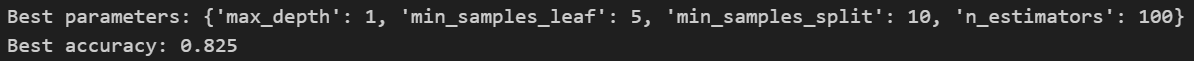

MLP

Epoch 20/1000, Loss 0.4106
Epoch 40/1000, Loss 0.3174
Epoch 60/1000, Loss 0.2601
Epoch 80/1000, Loss 0.2234
Epoch 100/1000, Loss 0.2265
Epoch 120/1000, Loss 0.2016
Epoch 140/1000, Loss 0.1887
Epoch 160/1000, Loss 0.1774
Epoch 180/1000, Loss 0.1761
Epoch 200/1000, Loss 0.1588
Epoch 220/1000, Loss 0.1573
Epoch 240/1000, Loss 0.1528
Epoch 260/1000, Loss 0.1455
Epoch 280/1000, Loss 0.1383
Epoch 300/1000, Loss 0.1322
Epoch 320/1000, Loss 0.1382
Epoch 340/1000, Loss 0.1254
Epoch 360/1000, Loss 0.1193
Epoch 380/1000, Loss 0.1135
Epoch 400/1000, Loss 0.1592
Epoch 420/1000, Loss 0.1176
Epoch 440/1000, Loss 0.1064
Epoch 460/1000, Loss 0.1012
Epoch 480/1000, Loss 0.0965
Epoch 500/1000, Loss 0.0929
Epoch 520/1000, Loss 0.1127
Epoch 540/1000, Loss 0.1182
Epoch 560/1000, Loss 0.0933
Epoch 580/1000, Loss 0.0867
Epoch 600/1000, Loss 0.0821
0.08 achieved, stopping learning process


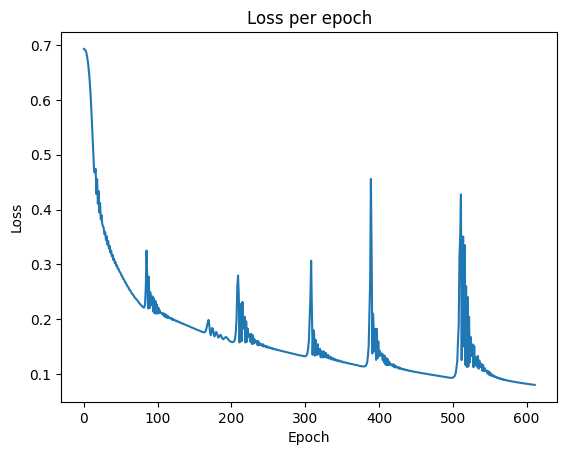

In [3]:
# Transform data sets into tensors
x_test_tensor = torch.tensor(x_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)
x_train_tensor = torch.tensor(x_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)

# Create MLP model
input_len = x_test_tensor.shape[1]
model_MLP = MLP_enzymes(input_len)

# Train model
train_mlp(model_MLP, x_train_tensor, y_train_tensor)

# Set model to evaluate
model_MLP.eval()

# Get predicted value
with torch.no_grad():
    y_predict_MLP = model_MLP(x_test_tensor)

    y_predict_probs = torch.sigmoid(y_predict_MLP)

    y_predict_classes = (y_predict_probs > 0.5).float().squeeze()

# Transform predicted values to numpy
    y_predict_classes_npy = y_predict_classes.cpu().numpy()

# Get evaluation metrics of MLP model
accuracy_MLP, f1_MLP, conf_matrix_MLP = evaluation_metrics(y_test, y_predict_classes_npy)

Results

---------- RANDOM FOREST ----------
Accuracy 0.7770
F1 Score 0.7780
[[1245  367]
 [ 352 1260]]
---------- MLP ----------
Accuracy 0.9494
F1 Score 0.9496
[[1527   85]
 [  78 1534]]


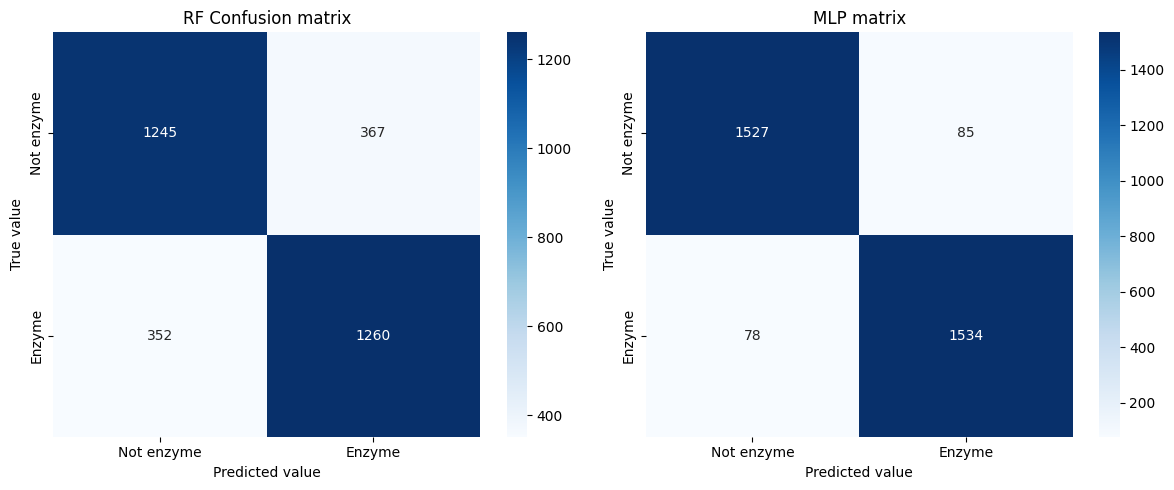

In [4]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Print evaluation metrics of RF
print("---------- RANDOM FOREST ----------")
print(f"Accuracy {accuracy_rf:.4f}")
print(f"F1 Score {f1_rf:.4f}")
print(f"{conf_matrix_rf}")

# Create RF heatmap of conf_matrix
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not enzyme', 'Enzyme'], yticklabels=['Not enzyme', 'Enzyme'],
            ax=axes[0])
axes[0].set_title('RF Confusion matrix')
axes[0].set_ylabel('True value')
axes[0].set_xlabel('Predicted value')

# Print evaluation metrics of MLP
print("---------- MLP ----------")
print(f"Accuracy {accuracy_MLP:.4f}")
print(f"F1 Score {f1_MLP:.4f}")
print(f"{conf_matrix_MLP}")

# Create MLP heatmap of conf_matrix
sns.heatmap(conf_matrix_MLP, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not enzyme', 'Enzyme'], yticklabels=['Not enzyme', 'Enzyme'],
            ax=axes[1])
axes[1].set_title('MLP matrix')
axes[1].set_ylabel('True value')
axes[1].set_xlabel('Predicted value')

# Print heatmaps
plt.tight_layout()
plt.show()

In [5]:
path_to_model = 'model/enzymes_MLP.pth'
torch.save(model_MLP.state_dict(), path_to_model)